# notMNIST dataset-based CW

## Data collection

### Objectives of the notebook:
* Collect data
* Clean data (remove files which are not images)
* Check for grayscale images
* Split dataset into 'train', 'validation' and 'test' subsets
### Input:
* Kaggle autentication token (kaggle.json)
### Output:
Generate dataset


In [37]:
import numpy as np
import os
from matplotlib.image import imread
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from tqdm import tqdm
import tarfile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras


2025-03-28 14:26:11.347776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 14:26:11.364723: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 14:26:11.568481: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 14:26:11.694408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743171971.908360    2239 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743171971.94

In [36]:
%pip install kaggle --silent  # install kaggle


Usage:   
  /home/codespace/.python/current/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /home/codespace/.python/current/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /home/codespace/.python/current/bin/python -m pip install [options] [-e] <vcs project url> ...
  /home/codespace/.python/current/bin/python -m pip install [options] [-e] <local project path> ...
  /home/codespace/.python/current/bin/python -m pip install [options] <archive url/path> ...

no such option: --silent
Note: you may need to restart the kernel to use updated packages.


In [22]:
os.chdir('/workspaces/m32895-coursework-2025')
print(f"Your current working directory is:\n {os.getcwd()}")

Your current working directory is:
 /workspaces/m32895-coursework-2025


In [23]:
# change the Kaggle configuration directory to the current working directory and set permissions for the Kaggle authentication JSON
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json

#### Download dataset

In [24]:
KaggleDatasetPath = "lubaroli/notmnist"
DestinationFolder = "/workspaces/m32895-coursework-2025/data_input"   
! kaggle datasets download -d {KaggleDatasetPath} -p {DestinationFolder}

Dataset URL: https://www.kaggle.com/datasets/lubaroli/notmnist
License(s): unknown


#### Unpack zip

In [25]:
with zipfile.ZipFile(os.path.join(DestinationFolder, 'notmnist.zip'), 'r') as notmnist_zip:
    notmnist_zip.extractall(DestinationFolder)


In [26]:
os.remove(os.path.join(DestinationFolder, 'notmnist.zip'))  # remove zip

#### Extract tar

In [27]:
file_path = "/workspaces/m32895-coursework-2025/data_input/notMNIST_small.tar.gz"
extract_path = "/workspaces/m32895-coursework-2025/data_input/notMNIST_small"

# Extract the tar.gz archive
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Extraction completed.")


Extraction completed.


### Check if images are valid

In [28]:
data_dir = "/workspaces/m32895-coursework-2025/data_input/notMNIST_small/notMNIST_small"

In [29]:
def check_valid_notmnist_images(data_dir, max_images_per_class=None):
    """
    Check if all images in the notMNIST dataset are valid.

    Args:
        data_dir (str): Path to the main dataset directory.
        max_images_per_class (int or None): Optional limit of images per class to check.

    Returns:
        invalid_images (list): List of invalid image file paths.
    """
    invalid_images = []
    total_valid = 0
    total_checked = 0

    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        files = os.listdir(class_dir)
        if max_images_per_class:
            files = files[:max_images_per_class]

        valid_count = 0
        for image_name in files:
            image_path = os.path.join(class_dir, image_name)
            try:
                with Image.open(image_path) as img:
                    img.convert("L").resize((28, 28))  # Simulate what loading does
                valid_count += 1
            except:
                invalid_images.append(image_path)

        total_checked += len(files)
        total_valid += valid_count
        print(f"Class '{class_name}': {valid_count}/{len(files)} images are valid.")

    print(f"\nTotal valid: {total_valid} / {total_checked}")
    print(f"Total invalid: {len(invalid_images)}")

    return invalid_images


In [30]:
bad_files = check_valid_notmnist_images(data_dir)

# Optional: delete broken files if needed
for bad in bad_files:
    os.remove(bad)

Class 'A': 1872/1873 images are valid.
Class 'B': 1873/1873 images are valid.
Class 'C': 1873/1873 images are valid.
Class 'D': 1873/1873 images are valid.
Class 'E': 1873/1873 images are valid.
Class 'F': 1872/1873 images are valid.
Class 'G': 1872/1872 images are valid.
Class 'H': 1872/1872 images are valid.
Class 'I': 1872/1872 images are valid.
Class 'J': 1872/1872 images are valid.

Total valid: 18724 / 18726
Total invalid: 2


### Load the dataset into Numpy

In [31]:
def load_notmnist_images(data_dir, max_images_per_class=1000):
    """
    Load notMNIST images into NumPy arrays.

    Args:
        data_dir (str): Path to the folder with subfolders A-J.
        max_images_per_class (int): Limit the number of images per class.

    Returns:
        X (np.ndarray): Image data of shape (num_samples, 28, 28).
        y (np.ndarray): Labels (0-9) corresponding to A-J.
    """
    X, y = [], []
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)[:max_images_per_class]

        for image_name in tqdm(image_files, desc=f"Loading class '{class_name}'"):
            image_path = os.path.join(class_dir, image_name)
            try:
                img = Image.open(image_path).convert("L").resize((28, 28))
                X.append(np.array(img))
                y.append(label)
            except:
                continue  # Skip unreadable or broken images

    X = np.array(X)
    y = np.array(y)
    return X, y


In [32]:
data_dir = "/workspaces/m32895-coursework-2025/data_input/notMNIST_small/notMNIST_small"
X, y = load_notmnist_images(data_dir)

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

Loading class 'J': 100%|██████████| 1000/1000 [00:00<00:00, 8878.69it/s]

Data shape: (10000, 28, 28), Labels shape: (10000,)


In [33]:
type(X)

numpy.ndarray

#### Get categories

In [34]:
import os

data_dir = "/workspaces/m32895-coursework-2025/data_input/notMNIST_small/notMNIST_small"
categories = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(categories)


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


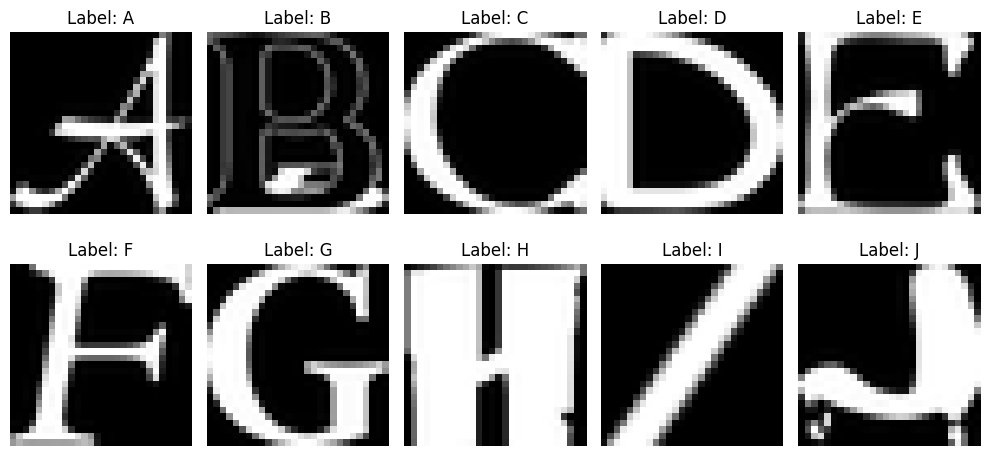

In [35]:
plt.figure(figsize=(10, 5))
for class_index in range(10):
    # Find indices where y == class_index
    class_indices = np.where(y == class_index)[0]
    
    # Pick one random index for that class
    i = np.random.choice(class_indices)
    
    plt.subplot(2, 5, class_index + 1)
    plt.imshow(X[i].squeeze(), cmap="gray")
    plt.title(f"Label: {categories[y[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


---

### Prepare dataset for Keras

In [41]:
# Normalize pixel values (optional)
X = X / 255.0
# Reshape images to fit CNN input (28x28x1)
X = X.reshape(-1, 28, 28, 1)

# Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical (one-hot encoding)
# y_train = keras.utils.to_categorical(y_train, num_classes=10)
# y_test = keras.utils.to_categorical(y_test, num_classes=10)

# Verify data shape
print(f"Dataset shape: {X.shape}")



Dataset shape: (10000, 28, 28, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Assume X is (10000, 28, 28, 1) and y is (10000,)
# First split: Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # We use stratify=y to preserve class distribution in each split.

# Second split: Validation (15%), Test (15%) from Temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check sizes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (7000, 28, 28, 1), Validation: (1500, 28, 28, 1), Test: (1500, 28, 28, 1)


### Plot label distribution in train, validation and test subsets

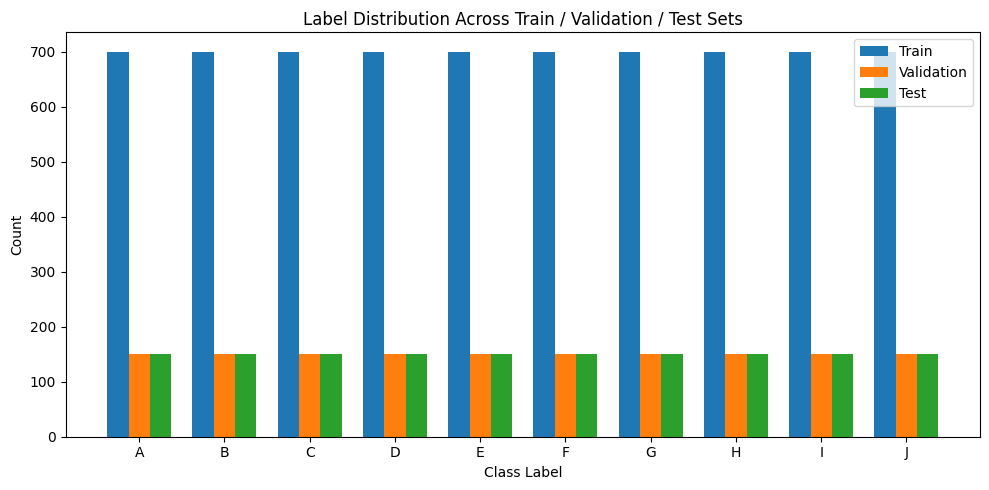

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution(y_sets, labels, set_names):
    num_sets = len(y_sets)
    num_classes = len(labels)

    # Create a bar chart for each dataset
    x = np.arange(num_classes)
    bar_width = 0.25

    plt.figure(figsize=(10, 5))

    for i, y_split in enumerate(y_sets):
        counts = np.bincount(y_split, minlength=num_classes)
        plt.bar(x + i * bar_width, counts, width=bar_width, label=set_names[i])

    plt.xticks(x + bar_width, labels)
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title("Label Distribution Across Train / Validation / Test Sets")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Define inputs
y_sets = [y_train, y_val, y_test]
set_names = ["Train", "Validation", "Test"]
plot_label_distribution(y_sets, labels=categories, set_names=set_names)


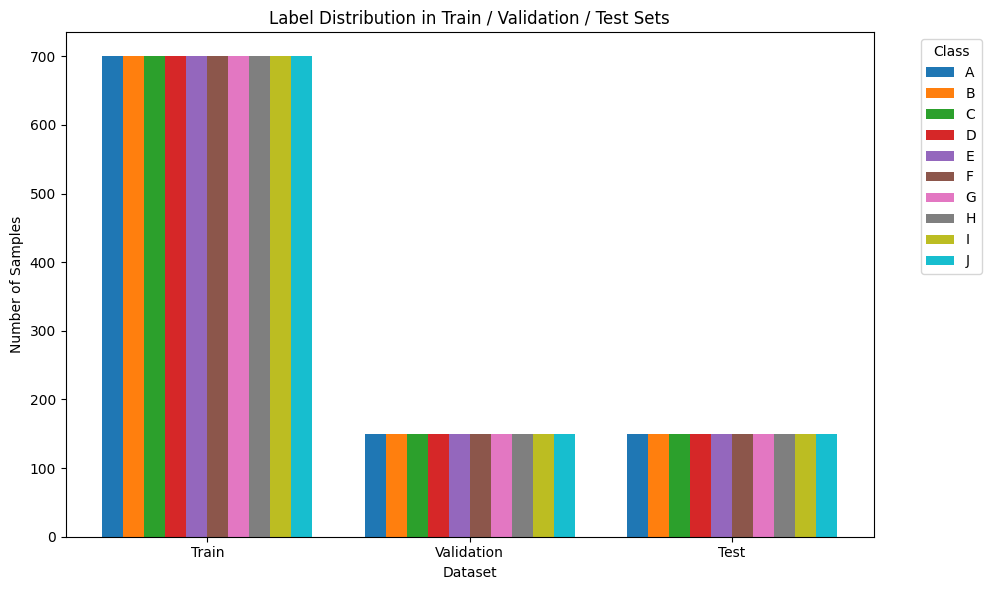

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution_grouped_by_dataset(y_sets, class_labels, set_names):
    num_classes = len(class_labels)
    num_sets = len(y_sets)

    # Count labels for each dataset
    counts_per_set = [np.bincount(y, minlength=num_classes) for y in y_sets]

    # Create bar positions
    x = np.arange(len(set_names))  # one group per dataset (Train/Val/Test)
    bar_width = 0.08

    plt.figure(figsize=(10, 6))

    for class_idx in range(num_classes):
        class_counts = [counts[class_idx] for counts in counts_per_set]
        plt.bar(x + class_idx * bar_width, class_counts, width=bar_width, label=class_labels[class_idx])

    plt.xticks(x + (num_classes / 2 - 0.5) * bar_width, set_names)
    plt.xlabel("Dataset")
    plt.ylabel("Number of Samples")
    plt.title("Label Distribution in Train / Validation / Test Sets")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Call the function
plot_label_distribution_grouped_by_dataset(
    y_sets=[y_train, y_val, y_test],
    class_labels=categories,
    set_names=["Train", "Validation", "Test"]
)
